In [16]:
from PIL import Image
import numpy as np
import torch
import albumentations as A
from torchvision.transforms.functional import to_tensor
from matplotlib import pyplot as plt
import tictactoe as ttt
import matplotlib.patches as patches

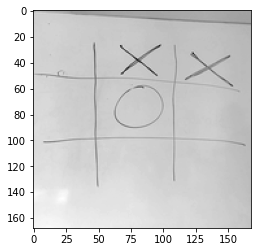

In [17]:
image = Image.open('0.jpg')
image = image.convert('L')
image = image.resize((168, 168), Image.ANTIALIAS)

plt.imshow(image, cmap='gray')

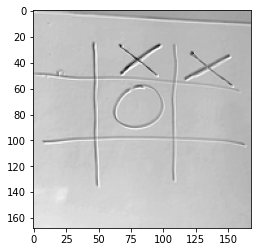

In [18]:
transform = A.Compose([
    A.InvertImg(p=0.18),
    A.ColorJitter(brightness=0.55, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
    A.GaussNoise(p=0.28),
    A.Blur(blur_limit=4, p=0.22),
    A.GlassBlur(max_delta=1, iterations=1, p=0.14),
    A.CLAHE(p=0.3),
    A.Sharpen(p=0.2),
    A.Emboss(p=0.18),
    A.Equalize(p=0.05),
    A.MultiplicativeNoise(p=0.22),
])

image1 = np.array(image)
image1 = transform(image=image1)['image']
plt.imshow(image1, cmap='gray')

In [19]:
def plot_image(image, boxes):
    im = np.array(image)
    height, width = im.shape

    fig, ax = plt.subplots(1)
    ax.imshow(im, cmap='gray')

    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)
    plt.show()

In [20]:
fieldModel = ttt.FieldModel()
fieldModel.load_state_dict(torch.load('tictactoeField.pth', map_location='cpu'))
fieldModel.eval()
boardModel = ttt.BoardModel()
boardModel.load_state_dict(torch.load('model5.pth', map_location='cpu'))
boardModel.eval()
print()

In [21]:
fieldDict = {
    '0': torch.zeros((1, 28, 28)),
    '1': torch.zeros((1, 28, 28)),
    '2': torch.zeros((1, 28, 28)),
    '3': torch.zeros((1, 28, 28)),
    '4': torch.zeros((1, 28, 28)),
    '5': torch.zeros((1, 28, 28)),
    '6': torch.zeros((1, 28, 28)),
    '7': torch.zeros((1, 28, 28)),
    '8': torch.zeros((1, 28, 28)),
}

confidenceDict = {
    '0': 0,
    '1': 0,
    '2': 0,
    '3': 0,
    '4': 0,
    '5': 0,
    '6': 0,
    '7': 0,
    '8': 0,
}

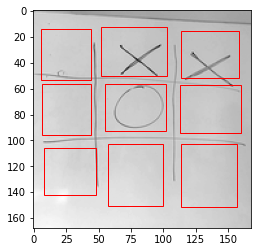

In [27]:
imageT = to_tensor(image).reshape(1, 1, 168, 168)
out = boardModel(imageT)
bboxes = ttt.cellboxes_to_boxes(out)
bboxes = ttt.non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.3, box_format="midpoint")
plot_image(image, bboxes)

In [28]:

for box in bboxes:
    class_idx = box[0]
    confidence = box[1]
    if confidence > confidenceDict[str(int(class_idx))]:
        x = box[2] * 168
        y = box[3] * 168
        w = box[4] * 168
        h = box[5] * 168
        im1 = image.crop(
            (x - w / 2, y - h / 2, x + w / 2, y + h / 2)
        )
        im1 = im1.resize((28, 28))
        fieldDict[str(int(class_idx))] = to_tensor(im1)
        confidenceDict[str(int(class_idx))] = confidence

fields = torch.stack(list(fieldDict.values()))

out = fieldModel(fields)
state = out.argmax(1).numpy().reshape(3, 3) - 1
print(state)

[[ 0  1  1]
 [ 0 -1  0]
 [ 0  0  0]]


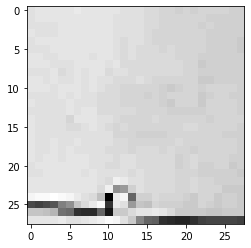

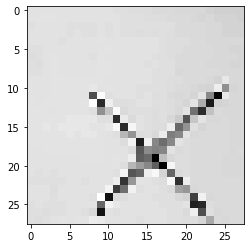

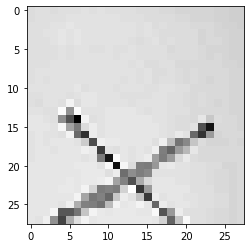

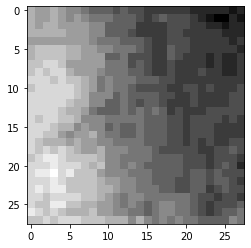

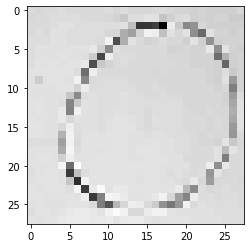

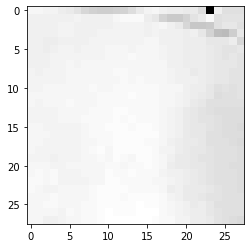

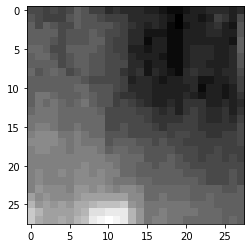

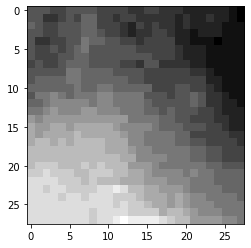

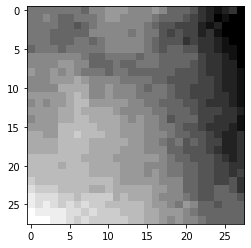

In [29]:
for field in fieldDict.values():
    fieldImg = field.numpy().reshape(28, 28)
    plt.imshow(fieldImg, cmap='gray')
    plt.show()